This script is used to create more complicated plants and controllers

In [35]:
import control as ct
import numpy as np
import matplotlib.pyplot as plt

In [36]:
def get_adaptive_hpf_for_2lpf(tau1, tau2, adaptive_func1, adaptive_func2):
    """
    params:
        gain: function t -> theta where theta is time-varying dc gain
    """
    A = np.array([[-1/tau1, 0], [0, -1/tau2]])
    B = np.array([[1/tau1], [1/tau2]])
    D = np.array([[1]])
    C = np.array([[adaptive_func1(0), -adaptive_func2(0)]])


    def update(t, x, u, params={}):
        return params['A'] @ x + params['B'] @ u
    
    def output(t, x, u, params={}):
        C = np.array([[-params['adaptive_func1'](t), -params['adaptive_func2'](t)]])
        return C @ x + params['D'] @ u
    
    params = {'A': A, 'B': B, 'D': D, 'adaptive_func1': adaptive_func1, 'adaptive_func2': adaptive_func2,
              'C': C}
    return ct.NonlinearIOSystem(
        update, output, inputs=['u'], outputs=['y'], states=2, params=params
    )

In [37]:
f1, f2 = lambda t: t, lambda t: t
sys = get_adaptive_hpf_for_2lpf(5, 20, f1, f2)

In [38]:
response = ct.input_output_response(sys, T=[0, 1, 2, 3], U=[0, 1, 0, -1])

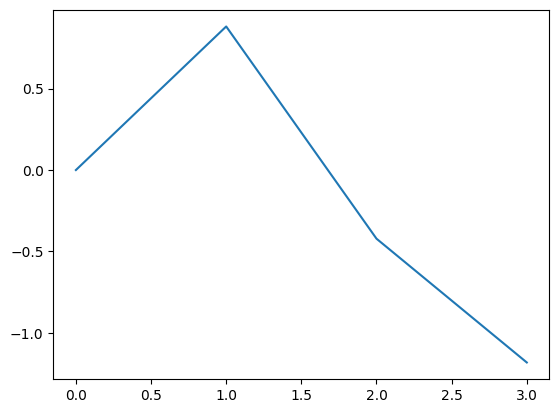

In [40]:
plt.plot(response.time, response.outputs)
plt.show()

## DVPP 1

In [1]:
import control as ct
import numpy as np
import sympy as sp

from check_qualification import *

In [ ]:
# DVPP 1
power_ratings_dict = {  # in MVA
    'DVPP': 250,
    'Hydro': 250,
    'BESS': 50,
    'SC': 25
}

tf_dict = {}  # systems IO TFs
pi_params = {  # PI and saturation controller parameters
    k: (-v, v) for k, v in power_ratings_dict.items()
}  

tau_PV, K_PV = 1.5, 1
tau_WTG, K_WTG = 2, 1
tau_BESS, K_BESS = 0.1, 1
tau_SC = 0.01

pi_params['PV'] = {"kp": 11.9, "ki": 157.9}
pi_params['Wind'] = {"kp": 11.9, "ki": 118}
pi_params['BESS'] = {"kp": 12, "ki": 2370}
pi_params['SC'] = {"kp": 12, "ki": 2370}
pi_params["Hydro"] = {"kp": -0.0796, "ki": -0.09788}

G_PV = ct.tf([K_PV], [tau_PV, 1])
G_WTG = ct.tf([K_WTG], [tau_WTG, 1])
G_BESS = ct.tf([K_BESS], [tau_BESS, 1])
G_SC = ct.tf([1], [tau_SC, 1])

: 

: 

In [ ]:
# build restricted battery model
p_BESS = {'tau': tau_BESS}  # maximum energy
def update(t, x, u, params={}):
    tau = params.get('tau')
    x0 = - 1/tau * x[0] + u[0]         # np.clip(u[0], -np.inf, E_max - x[1])
    x1 = x[0] #+ x[1]                  # energy state
    return [x0, x1]
def output(t, x, u, params={}):
    tau = params.get('tau')
    return 1/tau * x[0] / (1 + t**1.2)

G_BESS = ct.NonlinearIOSystem(
    update, output, inputs=['u'], outputs=['y'], states=2, params=p_BESS
)

tf_dict['BESS'] = G_BESS

# hydro
Rg, Rt = 0.03, 0.38
taug, taur, tauw = 0.2, 5, 1
s = sp.symbols('s')

def get_hydro_tf():
    T_hydro = -1/Rg / (taug*s + 1) * (taur*s+1) / (Rt/Rg*taur*s+1) * (1-tauw*s) / (1+1/2*tauw*s)
    return sympy_to_tf(sp.simplify(T_hydro))

T_hydro = get_hydro_tf() # * Gs['Wind'] # add typical delay
T_hydro = ct.tf(T_hydro.num, T_hydro.den, inputs=['u'], outputs=['y'])
tf_dict['Hydro'] = T_hydro

# build restricted supercap model
p_SC = {'tau': tau_SC}  # maximum energy
def update(t, x, u, params={}):
    tau = params.get('tau')
    x0 = - 1/tau * x[0] + u[0]         # np.clip(u[0], -np.inf, E_max - x[1])
    x1 = x[0] #+ x[1]                  # energy state
    return [x0, x1]
def output(t, x, u, params={}):
    tau = params.get('tau')
    return 1/tau * x[0] / (1 + t**3)

G_SC = ct.NonlinearIOSystem(
    update, output, inputs=['u'], outputs=['y'], states=2, params=p_SC
)

: 

: 

In [ ]:
IO_dict = {('Hydro'): (T_hydro, 'lpf'),
           ('BESS'): (G_BESS, 'bpf'),
           ('SC'): (G_SC, 'hpf')}

my_names = list(IO_dict.keys())

saturation_dict = {
    name: (-power_ratings_dict[name], power_ratings_dict[name]) for name in my_names
}

# add saturation dict to pi params
for k, v in saturation_dict.items():
    pi_params[k]['saturation_limits'] = v

: 

: 

In [ ]:
service_rating = 200  # in MW
Dp = 1/service_rating
MP_max = 250/200 * Dp
T_MAX_FFR = 10
require_ffr = {(0, .7): (0, 0), (.7, 5): (1/Dp, 1/Dp), (5, T_MAX_FFR): (1/Dp, 0)}
require_ffr_max = {(0, .7): (0, MP_max), (.7, 5): (MP_max, MP_max), (5, 10): (MP_max, 0)}
ts_ffr_max, input_ffr_max = create_curve(require_ffr_max, t_max=T_MAX_FFR)
_, curve_ffr_min = create_curve(require_ffr, t_max=T_MAX_FFR)

: 

: 

In [ ]:
# simulate
from get_max_reward import simulate_devices_and_limits

VALUE, ENERGY, PEAK_POWER, SHAPELY_VALS = simulate_devices_and_limits(
                              IO_dict=IO_dict,
                              pi_params=pi_params,
                              input_service_max=require_ffr_max,
                              curve_service_min=require_ffr,
                              title='FFR-FCR Response',
                              save_path='pics/FFR'
)

: 

: 

## BESS

From https://www.mdpi.com/1996-1073/14/4/1182 figure 2

In [ ]:
import control as ct
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

: 

: 

In [ ]:
w_error = ct.summing_junction(['wref', '-w'], 'w_error')

: 

: 

In [ ]:
params = {'kp': 0.5, 'ki': 0.1, 'kd': 0.01}

def get_pi_controller(params):
    # old: without saturation
    return ct.tf(
        [params['kp'], params['ki']], [1, 0],
        inputs=['e'], outputs=['u']
    )

pi = get_pi_controller(params)

ct.tf2ss(pi)

StateSpace(array([[-0.]]), array([[1.]]), array([[0.1]]), array([[0.5]]))

: 

: 